In [1]:
# Import all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

In [3]:
# This function takes a dataframe and a column with categorical data and gives the number 
# of occurrances of each distinct entry, with error bars (which are computer by bootstrapping).
# The output is given in the form {distinctentry: [total(on average),errorbars], ...}
def getCompositionAndErrorbar(thedataframe, columnname, num_iterations = 1000):
    categories = thedataframe[columnname].unique()
    sizesample = thedataframe.shape[0]
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        totalsofcategories = [(sampledcolumn == cat).sum() for cat in categories]
        sampletotals.append(totalsofcategories)
    sampletotals = np.transpose(np.array(sampletotals))
    numofcasesanderrors = dict([(categories[ij], [totals.mean(), totals.std()]) for (ij,totals) in enumerate(sampletotals)])
    return numofcasesanderrors

# Draws a barplot showing the total number of elements in a given column of a given dataframe,
# with error bars, using the function getCompositionAndErrorbar.
def drawBarPlotOfTotals(thedataframe, columnname, num_iterations = 1000):
    totalsanderrors = getCompositionAndErrorbar(thedataframe,columnname,num_iterations=num_iterations)
    indices = [ind for ind in totalsanderrors]
    mean_and_std_dataframe = pd.DataFrame({"Mean": [totalsanderrors[ind][0] for ind in indices], 
              "StandardDeviation": [totalsanderrors[ind][1] for ind in indices]}, index=indices).sort_index()
    mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"])
    plt.xlabel(columnname)
    plt.ylabel("Total")
    plt.title("Composition of "+columnname)
    plt.show()

# Returns the error bars and bins of a histogram of a quantitative column by bootstrapping the histogram counts
def getHistogramErrorbar(thedataframe, columnname, num_iterations = 1000):
    sizesample = thedataframe.shape[0]
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        sampletotals.append(np.histogram(sampledcolumn))
    binvalues = np.transpose(np.array([histogramvalues[0] for histogramvalues in sampletotals]))
    histogramdata = ([binval.std() for binval in binvalues] , sampletotals[0][1])
    return histogramdata

# Draws a histogram of a given quantitative column of a given dataframe,
# with error bars, using the function getHistogramErrorbar.
def drawHistogramWithErrorbars(thedataframe, columnname, num_iterations = 1000):
    (histerrorbars, bins) = getHistogramErrorbar(thedataframe, columnname, num_iterations)
    (n, bins, _) = plt.hist(thedataframe[columnname], bins=bins, histtype = 'step')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=histerrorbars, fmt='none')
    plt.xlabel(columnname)
    plt.ylabel("Total")
    plt.title("Distribution of "+columnname)
    plt.show()

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:


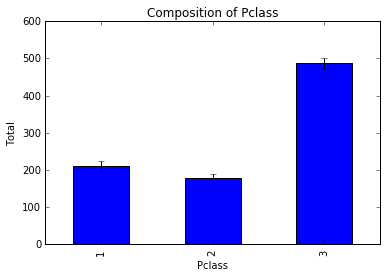

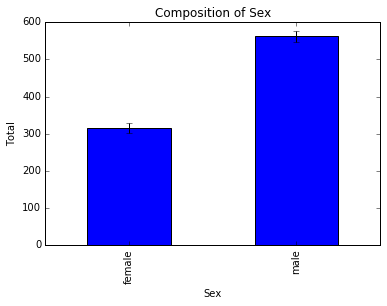

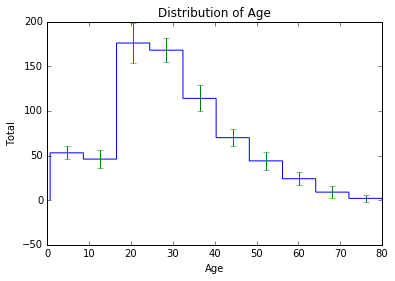

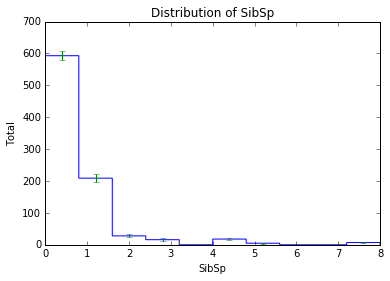

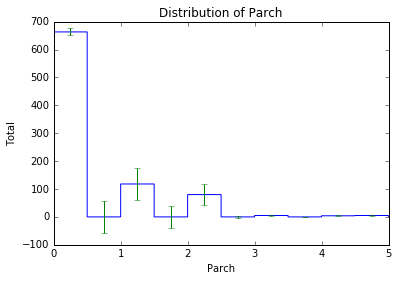

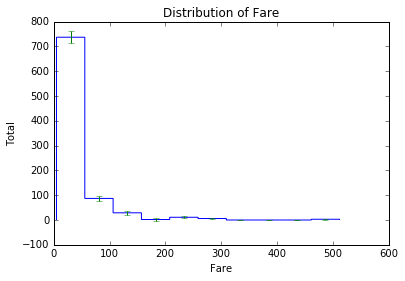

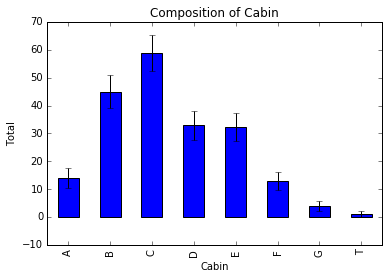

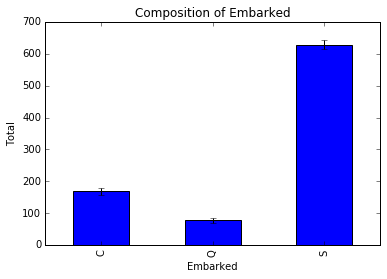

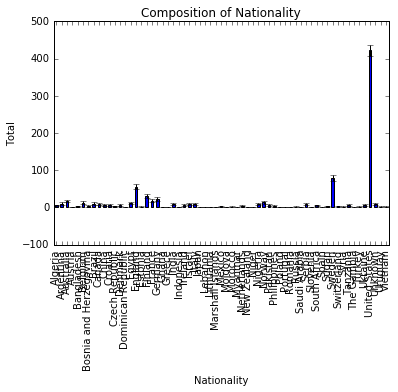

In [4]:
#================================================================================================
# USER INPUT!
# We shall now do som  global exploratory analysis on our data. We will later segment the data and
# perform an analysis on each 
# We need to know what category of data we have in each column: 
# - "C": categorical (can do =, !=)
# - "O": ordinal (can do =, !=, >, <)
# - "QC": quantative comparison (zero unimportant, e.g. time stamps) (can do =, !=, >, <, +, -)
# - "QA": quantative absolute (zero important, e.g. length) (can do =, !=, >, <, +, -, * , /)
# This information will be in the form of a dictionary, for each data table

datacategories = [ # we put "Survived" as "QA" because we interpret it as a survival probability
    {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C", 
     'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
     'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
]

# It is useless to find the copmosition of certain columns, since they are nearly all different
# and are hence more similar to a unique identifier
uselesscolumns = [
    ["Survived", "Name", "Ticket"]
]

# In each column, some entries are unknown and have been filled by by e.g. "X". We would
# like to remove these when looking at the compositions. You might need to look in the 
# CleaningNotebook to find out what the unknown entries are called
unknowns = [
    {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
     "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
     "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0]}
]

#================================================================================================

# FROM HERE ON IT'S AUTOMATIC
# We'll first do some descriptive work on our data: for "C" and "O", it's good to know the 
# proportions of each of the categories (and their total). For "QC" and "QA" we would like to have a 
# distribution of the data. Ideally, we would always like to see error bars on everything.

for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    for col in alldataframes[ii]:
        if (datacategories[ii][col]=="C" or datacategories[ii][col]=="O") and (col not in uselesscolumns[ii]):
            if col in unknowns[ii]:
                drawBarPlotOfTotals(alldataframes[ii][alldataframes[ii][col]!= unknowns[ii][col]],col)
            else:
                drawBarPlotOfTotals(alldataframes[ii],col)
        if (datacategories[ii][col]=="QA" or datacategories[ii][col]=="QC") and (col not in uselesscolumns[ii]):
            if col in unknowns[ii]:
                drawHistogramWithErrorbars(alldataframes[ii][alldataframes[ii][col]!= unknowns[ii][col]], col)
            else:
                drawHistogramWithErrorbars(alldataframes[ii], col)

In [ ]:
# NOW WE'LL WORK ON SEGMENTED DATA (ALSO LOOK IN HOMEWORK 4). 
# FOR EACH SEGMENT PLOT THE OTHER COLUMNS. EACH TIME
# WE PLOT ANOTHER COLUMN, WE ALSO COMPARE TO THE GLOBAL DATA. IF OUR
# SEGMENT WE'RE STUDYING BREAKS UP INTO MANY 

In [87]:
thedata["Age"][abs(thedata["Age"] - thedata["Age"].mean()) < 0.2].unique()[0]

29.6991176471

In [63]:
thedata = alldataframes[0]

In [6]:
thedata.groupby("Pclass").mean()["Survived"]

Pclass
1    0.644550
2    0.488764
3    0.242300
Name: Survived, dtype: float64

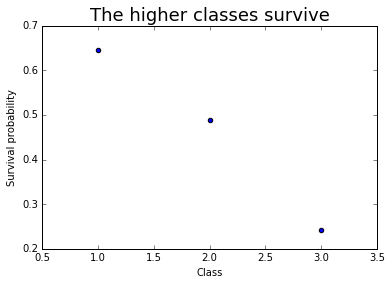

In [7]:
plt.scatter(thedata.groupby("Pclass").mean()["Survived"].index, thedata.groupby("Pclass").mean()["Survived"])
plt.xlabel("Class")
plt.ylabel("Survival probability")
plt.title("The higher classes survive", {"fontsize":18} )
plt.show()

In [8]:
newframe = thedata["Survived"].to_frame()
newframe["AgeGroup"] = pd.cut(thedata["Age"],40)

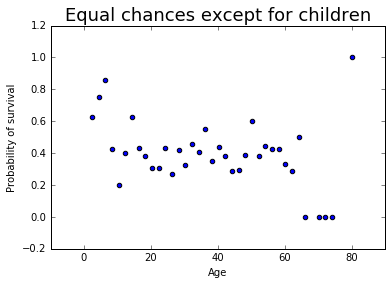

In [9]:
plt.scatter([float(x[x.find(",")+2:-1]) for x in newframe.groupby("AgeGroup").mean()["Survived"].index], newframe.groupby("AgeGroup").mean()["Survived"])
plt.xlabel("Age")
plt.ylabel("Probability of survival")
plt.title("Equal chances except for children", {"fontsize": 18})

In [10]:
thedata.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Nationality
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,XXX,S,United States
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,United States
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,XXX,S,Finland
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,United States
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,XXX,S,United States


<Container object of 2 artists>

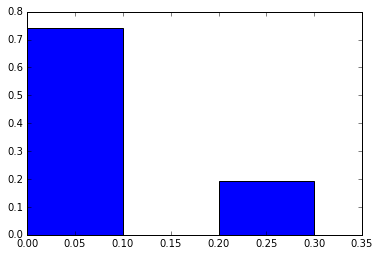

In [11]:
plt.bar([0,0.2],thedata.groupby("Sex").mean()["Survived"],width=0.1)
# Chance for men and women to survive

In [163]:
# What is the distribution of Pclass, Sex, Age, Fare, Nationality?
# Figure out what kind of plot is best for what kind of correlations